In [4]:
import pandas as pd
import seaborn as sns
import os

In [5]:
dfs = []

bench_dir = "bench"

for cmd in os.listdir(bench_dir):
    for store_config in os.listdir(os.path.join(bench_dir, cmd)):
        parts = store_config.split("-")
        store = parts[0]
        tls = parts[1] == "tls"
        enclave = parts[2]
        
        file = os.path.join(bench_dir, cmd, store_config, "timings.csv")
        if not os.path.exists(file):
            continue
        df = pd.read_csv(file)
        start = df['start_micros'].min()
        df['start_micros'] -= start
        df['end_micros'] -= start
        df['latency_ms'] = (df['end_micros'] - df['start_micros']) / 1000
        df["cmd"] = cmd
        df["store"] = store
        df["tls"] = tls
        df["enclave"] = enclave
        dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)
all_data.head()

,start_micros,end_micros,latency_ms,cmd,store,tls,enclave
0,0,48817,48.817,txn-put,ccfkvs,True,virtual
1,48843,50397,1.554,txn-put,ccfkvs,True,virtual
2,50400,51863,1.463,txn-put,ccfkvs,True,virtual
3,51866,53298,1.432,txn-put,ccfkvs,True,virtual
4,53300,102521,49.221,txn-put,ccfkvs,True,virtual


In [6]:
all_data[all_data.latency_ms < 0]

,start_micros,end_micros,latency_ms,cmd,store,tls,enclave
65062,344557,336633,-7.924,txn-mixed_txn-mixed-key,etcd,True,virtual
65544,1307623,1298177,-9.446,txn-mixed_txn-mixed-key,etcd,True,virtual
65664,1548343,1528059,-20.284,txn-mixed_txn-mixed-key,etcd,True,virtual
70120,274855,262435,-12.420,txn-mixed_txn-mixed-key,etcd,False,virtual
70602,1128478,1118966,-9.512,txn-mixed_txn-mixed-key,etcd,False,virtual
70722,1343541,1321084,-22.457,txn-mixed_txn-mixed-key,etcd,False,virtual
95883,345988,344320,-1.668,range_range-key,etcd,False,virtual


In [7]:
all_data = all_data[all_data.latency_ms >= 0]

In [8]:
all_data["store_tls"] = all_data["store"] + "_" + all_data["tls"].map(lambda t: "tls" if t else "plain")

In [9]:
all_data

,start_micros,end_micros,latency_ms,cmd,store,tls,enclave,store_tls
0,0,48817,48.817,txn-put,ccfkvs,True,virtual,ccfkvs_tls
1,48843,50397,1.554,txn-put,ccfkvs,True,virtual,ccfkvs_tls
2,50400,51863,1.463,txn-put,ccfkvs,True,virtual,ccfkvs_tls
3,51866,53298,1.432,txn-put,ccfkvs,True,virtual,ccfkvs_tls
4,53300,102521,49.221,txn-put,ccfkvs,True,virtual,ccfkvs_tls
...,...,...,...,...,...,...,...,...
105053,3590910,3591388,0.478,range_range-key,etcd,False,virtual,etcd_plain
105054,3591389,3591801,0.412,range_range-key,etcd,False,virtual,etcd_plain
105055,3591804,3592204,0.400,range_range-key,etcd,False,virtual,etcd_plain
105056,3592205,3592480,0.275,range_range-key,etcd,False,virtual,etcd_plain


In [13]:
# make the plots dir
os.makedirs("plots", exist_ok = True)

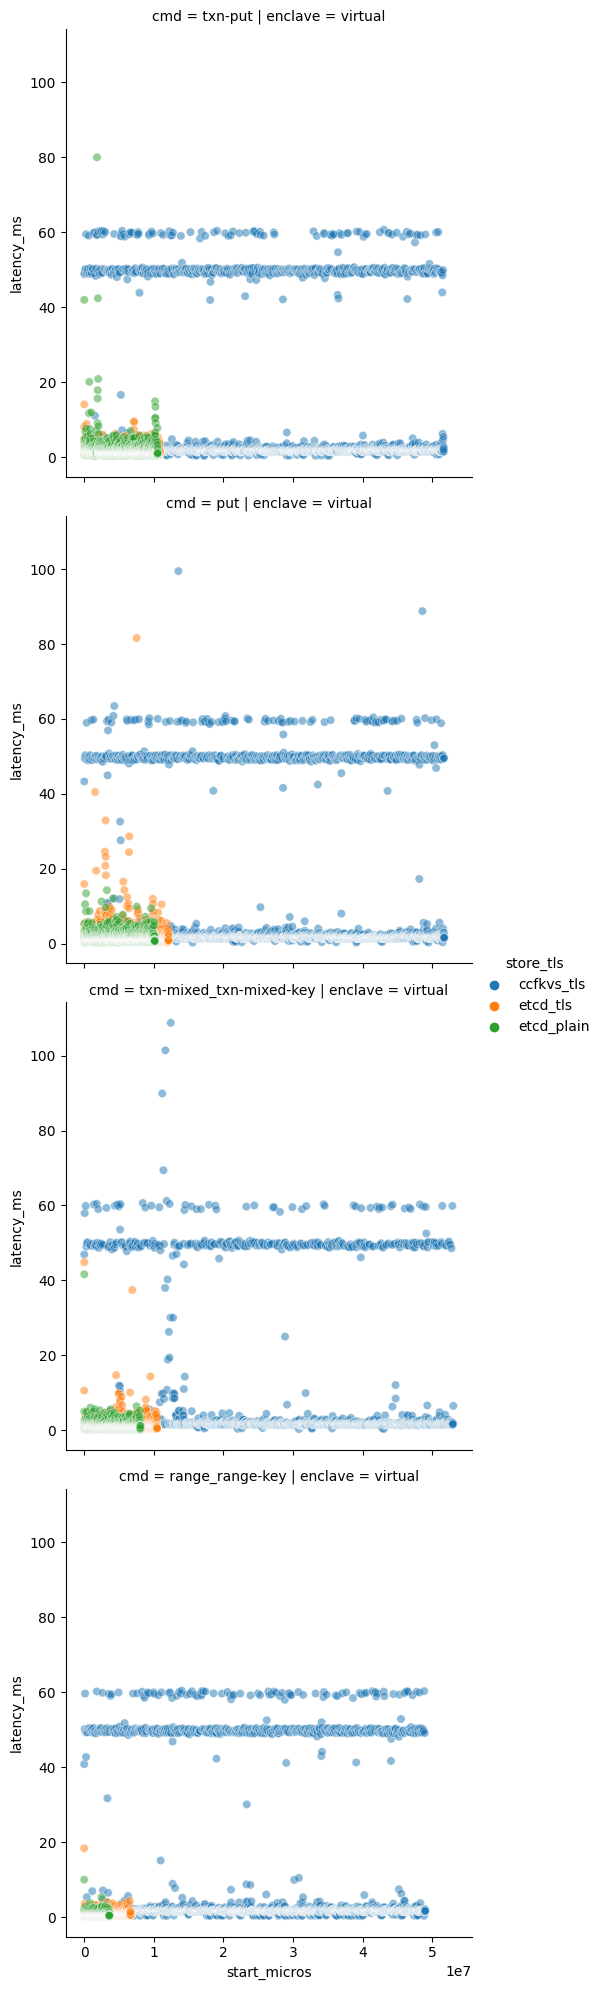

In [14]:
p = sns.relplot(kind="scatter", data=all_data, x="start_micros", y="latency_ms", row="cmd", col="enclave", hue="store_tls", alpha=0.5)
p.savefig("plots/scatter.svg")

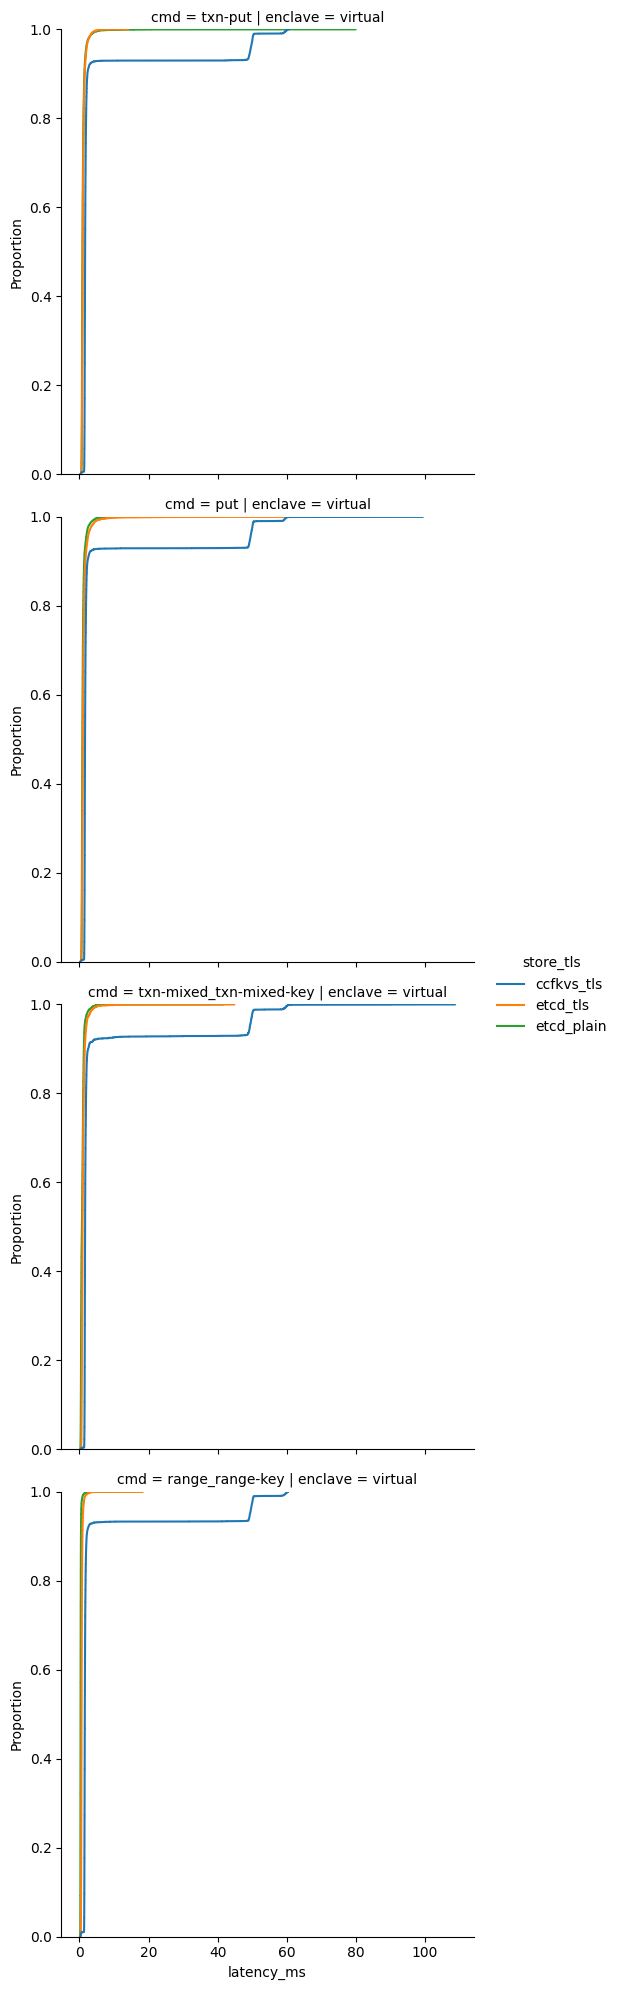

In [15]:
p = sns.displot(kind="ecdf", data=all_data, x="latency_ms", row="cmd", col="enclave", hue="store_tls")
p.savefig("plots/ecdf.svg")